# Task 2 find negative values

Given a list of integer numbers, look for a negative number in the list. Consider an appropriate number of qubits and explain why your proposal is valid for all kinds of numbers in case 


def find_negative_numbers(list[int]:list_number):
     “””
list_number : integer list!.
Return the True or False depends of the input
     “””

     # use a framework that works with quantum circuits, qiskit, cirq, pennylane, etc. 


      # consider print your quantum circuit,


Example:

A = find_negative_numbers([1,-3,2,15])
print(A)

“True”


B = find_negative_numbers([1,4,8,11])
print(B)

“False”


B = find_negative_numbers([-15,-14,2,-1])
print(B)

“True”


## Imports

In [141]:
from math import ceil, log
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_bloch_multivector, array_to_latex
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import GroverOperator
from qiskit.circuit.library.standard_gates import CXGate, MCXGate
from qiskit.algorithms import AmplitudeEstimation, EstimationProblem, MaximumLikelihoodAmplitudeEstimation, IterativeAmplitudeEstimation
from qiskit.extensions import UnitaryGate
from qiskit.utils import  QuantumInstance
import numpy as np

## Solution Overview 

The challenge for this particular problem is in solving it on a Quantum Computer. On its own, the problem is solved easily by checking for each elements of the array one by one. However, when solving on a quantum computer, there are a couple challenges. 

1. Encoding the elements in the array into the qubits
2. Determining whether an integer, encoded in the qubits, is negative


Each of these challenges and their solutions have been described below the respective functions which resolve them.



### 1. Encoding the Elements  

Encoding the elements in the array implies that corresponding to each element in the array, its binary encoded string should be output equally likely on measurement of the encoding qubits, without any processing on them. 

Here two sets of qubits are used. The first set is used to encode the indices of the array, and the second set is used to encode the actual integer elements of the array. 

Corresponding to each element's bit string a controlled gate is generated which can encode the bit string onto the qubits. The control for the respective gates is set as the bit string encoding the index, which is encoded the first set of registers. 
Each of the index encoding registers is in an equal superposition, hence the probability of an index being selected among the other indices is equal, thus implying that each element in the array has the same probability.

This functionality is implemented by the 'load_inputs' function below

In [142]:
def load_inputs(m, n, vector, vectorbit):  
    a=QuantumRegister(n, 'a')                               # address
    d=QuantumRegister(m, 'd') 
    obj = QuantumRegister(1, 'obj')                              # data
    c = ClassicalRegister(1, 'c')
    qcm=QuantumCircuit(a, d, obj, c)

    qc = QuantumCircuit(a, d, obj)
    qc.h(a)                                 # An algorthm to load the given classical data into the ∣d⟩ (data) quibits
    for i in range(len(vector)):
        gate_dict={'0': 'I', '1': 'X'}
        gate_name = '-'.join([gate_dict[b] for b in vectorbit[i]])
        gate_name = '|{}⟩: '.format(vector[i]) + gate_name
        circ = QuantumCircuit(m, name=gate_name)
        for j in range(m):
            if vectorbit[i][j]=='1':
                circ.x(j)
        
        # multi-x gate
        mx_gate = circ.to_gate()

        # multi-polarity multi-control multi-x gate
        mpmcmx_gate = mx_gate.control(n, ctrl_state='{0:0{size}b}'.format(i, size=n)[::-1])
        qc.append(mpmcmx_gate, range(m+n))
    qc.cx(d[0], obj)
    qcg = qc.to_gate()


    qco = QuantumCircuit(a, d, obj)
    qco.cz(obj, d[0])


    qcref = QuantumCircuit(a, d, obj)
    zero = np.zeros(2)
    ref_gate = UnitaryGate(2*np.outer(zero, zero)-np.identity(2))
    # qcref.cz(obj, d[0])
    qcref.append(ref_gate, [n])


    # qcgr = GroverOperator(qco, qc, reflection_qubits= [n]) 
    qcgr = GroverOperator(qco, qc, qcref)

    # print(qcgr.decompose().draw())

    problem = EstimationProblem(
    state_preparation=qc,  # A operator
    # grover_operator=qcgr,  # Q operator
    objective_qubits=[n],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)
    # qcgi = qcg.inverse()
    qcm.append(qcg, range(m + n + 1))

    qcm.measure(d[0], c)
    # print(qcm.draw())
    return problem

### 2. Determine Negative Elements in Encoded Qubits 

To determine whether the integer which has been encoded is negative or not, requires a workaround when encoding the elements. The workaround used here is that if an integer can be encoded in its 2's complement representation, the MSB (Most Significant Bit) can be measured to determine whether the encoded integer is positive or negative. In case of a negative integer, the MSB is always 1, whereas for a positive integer it will be 0. This has been coded into the function itself. 

Inside the function ("find_negative_numbers" below) when it is encoding a number, firstly it determines the number of qubits for encoding the integers (m) by adding 1 to the length of the bitstring for the maximum or minimum value of the array. (In case when negative integers are present, length of the bitstring can be greater than that of other elements in the array). When 2's complement of each integer is computed w.r.t (2**m - 1), the resulting bitstring is always such that there is a 1 in the MSB, if the integer is negative. 

Now, as this is a distinguishing factor, this can be made use of by the function to return whether the array contains a negative integer or not. To do so, we make use of Amplitude Estimation algorithm. This is an algorithm which provides an estimate of the count/probability of good states in a given set of quantum states. With the help of Amplitude Estimation, the number of shots required are significantly reduced. Here I have made use of Amplitude Estimation and Estimation Problem functions in qiskit. If amplitude estimation on the objective qubit (in this case, the MSB) returns 1, the function returns True, implying the array contains a negative integer , else it returns False.

In [214]:
def find_negative_numbers(vector):
    # n = mimimum number of quibits required to store the addresses of the input
    n=ceil(log(len(vector), 2))

    vector=np.asarray(vector, dtype=int)
    
    # m = minimum number of bits required to store the largest number in the input,
    # m is also the minimum number of qubits required to store all the numbers in the input
    m=max([len('{0:b}'.format(max(vector))), len('{0:b}'.format(np.min(vector)))]) + 1

    vectorbit=[]
    for num in vector:
        
        bin_num = bin(num & (2**m - 1)).replace('0b', '')
        bin_num = '0'*(m - len(bin_num)) + bin_num
        vectorbit.append(bin_num)

    print(m + n + 1)
    backend = BasicAer.get_backend('qasm_simulator')
    problem = load_inputs(m, n, vector, vectorbit)
    # n_shots = int(round(np.sqrt(len(vector)), 0))
    n_shots = 10
    quantum_instance  = QuantumInstance(backend= backend, shots = n_shots)
    print(n_shots)
    # ae = AmplitudeEstimation(m + n + 1, quantum_instance = quantum_instance)
    mlae = MaximumLikelihoodAmplitudeEstimation(2, quantum_instance= quantum_instance)
    # iqae = IterativeAmplitudeEstimation(0.01, 0.05, quantum_instance= quantum_instance)
    res = mlae.estimate(problem)
    res_qc = mlae.construct_circuits(problem)
    display(res_qc[2].draw('mpl'))
    print(res.estimation)
    print(res.estimation_processed)
    if np.isclose(res.estimation_processed, 0):
        return False
    else:
        return True
    # counts = execute(qc, backend, shots= 1000).result().get_counts()
    # if '1' in counts.keys():
    #     return True
    # else: 
    #     return False
    

## Test Cases

In [215]:
# declare test cases
test_cases = []
test_cases.append([-1, 2, 3, 4, 5, 6, 7])
# test_cases.append([10, 5, -20, 63, 22]) #case 1
# test_cases.append([1,-3,2,15]) #case 2
# test_cases.append([1,4,8,11]) #case 3
# test_cases.append([-15,-14,2,-1]) #case 4

8
10


C:\Users\hgak7\AppData\Local\Temp\ipykernel_10312\3971666936.py:23: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance  = QuantumInstance(backend= backend, shots = n_shots)
C:\Users\hgak7\AppData\Local\Temp\ipykernel_10312\3971666936.py:26: DeprecationWarning: ``qiskit.algorithms.amplitude_estimators.mlae.MaximumLikelihoodAmplitudeEstimation.__init__()``'s argument ``quantum_instance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the ``sampler`` argument. See https://qisk.it/algo_migration for a migration guide.
  mlae = MaximumLikelihoodAmplitudeEstimation(2, quantum_instance= quantum_instance)


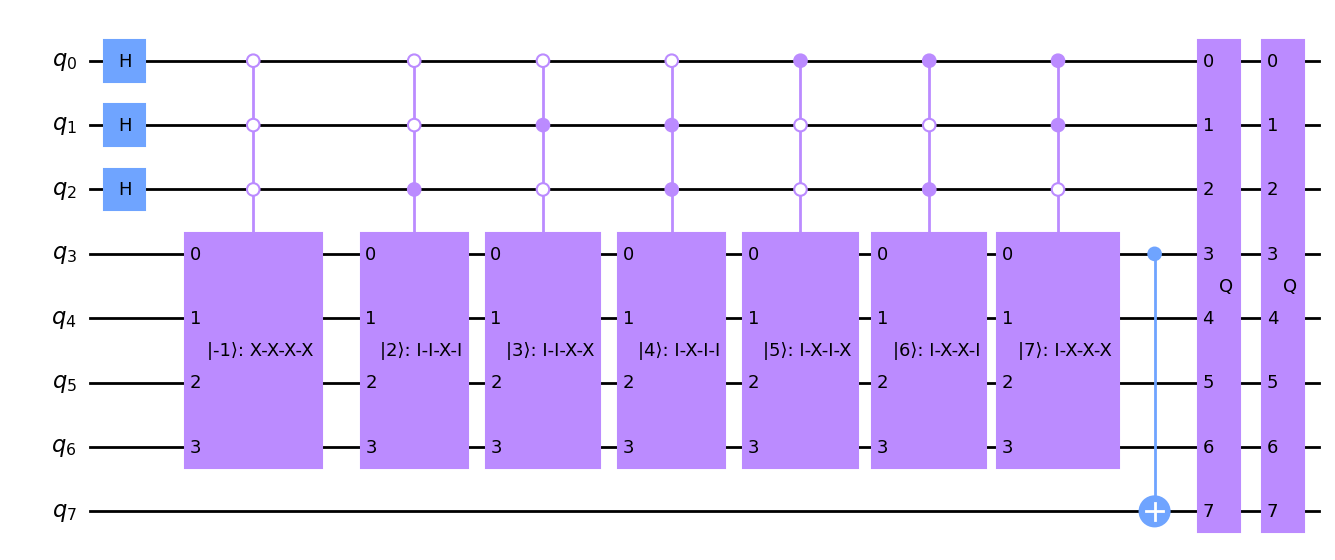

0.11306845275304721
0.11306845275304721
True


In [216]:
for i in test_cases:
    print(find_negative_numbers(i))

## Circuit 

The circuit for Amplitude Estimation for m = 2 is as below

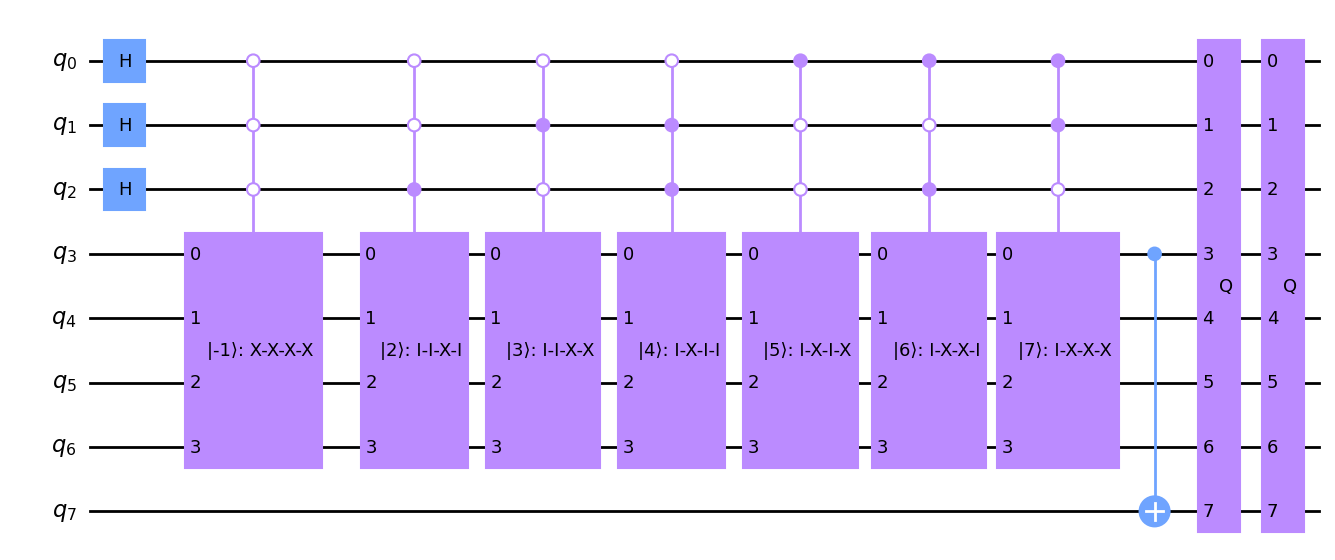